In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Read preprocessed Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_2021_CO2_Project_Fr_preprocessed.csv')

#Split Features and Target

df['Ewltp_g/km'] is splitted into 7 CO2 Emission classes


In [ ]:
target = pd.cut(x=df['Ewltp_g/km'], bins=[0, 100, 120, 140, 160, 200, 250, np.inf], labels=['0', '1', '2', '3', '4', '5', '6'], right=True)

In [ ]:
data = df.drop('Ewltp_g/km', axis=1)

##Dropping highly correlated Features

In [ ]:
data = data.drop('Fc', axis=1)
data = data.drop('Er_km', axis=1)


#Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler, ADASYN

print(f'Data shape before over-sampling {data.shape}')
ros = RandomOverSampler()
data_ros, target_ros = ros.fit_resample(data, target)
print(f'Data shape after over-sampling {data_ros.shape}')


Data shape before over-sampling (1589748, 28)
Data shape after over-sampling (4808811, 28)


#Scaling


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

def split_scale(X, y, test_size=0.3, scaler_to_apply=StandardScaler, random_state=123):
  #Split data to test/train
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

  #Apply scaling
  scaler = scaler_to_apply()
  scaler.fit(X_train, y_train)
  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_test_scaled, y_train, y_test

#Split original Dataset
X_train, X_test, y_train, y_test = split_scale(data, target, scaler_to_apply=StandardScaler)

#Split Oversampled Dataset
X_train_ros, X_test_ros, y_train_ros, y_test_ros = split_scale(data_ros, target_ros, scaler_to_apply=StandardScaler)



#Deep Learning

##Import Libraries

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

import itertools
from sklearn import metrics
import pickle

##Plot Loss & Accuracy

In [ ]:
def plot_acc_loss(history):
  '''
  Allows to plot evolution of Training and Validation over Epochs for both accuracy and loss
  Input:
    -history ('.history' attribute from .fit() method output)
  Output:
    -Displays 2 plots (accuracy/loss) on the same line
  '''
  #Extract Validation accuracy and loss
  loss_valid = history['val_loss']
  acc_valid = history['val_accuracy']

  #Extract Training accuracy and loss
  loss_train = history['loss']
  acc_train = history['accuracy']

  plt.figure(figsize=(8, 4))

  #Subplot for loss
  plt.subplot(121)
  plt.plot(np.arange(len(loss_valid)), loss_valid, label='Validation')
  plt.plot(np.arange(len(loss_train)), loss_train, label='Training')
  plt.legend()
  plt.title('loss')

  #Subplot for accuracy
  plt.subplot(122)
  plt.plot(np.arange(len(acc_valid)), acc_valid, label='Validation')
  plt.plot(np.arange(len(acc_train)), acc_train, label='Training')
  plt.title('accuracy')
  plt.legend()

  #Save Screenshot
  plt.savefig('model_history.png', bbox_inches='tight')

  plt.show();
  return

## Prepare Data for DNN

In [ ]:
def prepare_data_for_dnn(X_train_initial, y_train_initial, X_test, y_test, validation_train_ratio=0.05):
  '''
  Preprocess data for Keras deep learning models
    -Split train data to Train/Validation

  Input:
    -Presplitted Test/Train Data:
      Train Data: X, y
      Test Data: X_test, y_test
    -validation_train_ratio : factor(0,1) representing size of validation data relatively
                              to Train data (X_train_initial, y_train_initial)
  Returns:
    - A list of tuples (X_train_dnn, y_train_dnn), (X_test_dnn, y_test_dnn), (X_valid_dnn, y_valid_dnn)
  '''

  #Split Train data to Train/Validation
  X_train, X_valid, y_train, y_valid = train_test_split(X_train_initial, y_train_initial, test_size=validation_train_ratio)

  #Make sure data's type is float
  X_train_dnn = X_train.astype(float)
  X_test_dnn = X_test.astype(float)
  X_valid_dnn = X_valid.astype(float)

  y_train_dnn = y_train.astype(float)
  y_test_dnn = y_test.astype(float)
  y_valid_dnn = y_valid.astype(float)


  #y_train_dnn -= 1
  #y_test_dnn -= 1
  #y_valid_dnn -= 1

  # Create output list of tuples for each category from Train/Test/Validation
  output = (X_train_dnn, y_train_dnn), (X_test_dnn, y_test_dnn), (X_valid_dnn, y_valid_dnn)
  for x, y in output:
    print(x.shape)
    print(y.shape)
  return output

## Pickle dump function

In [ ]:
def pickle_model_evaluation_data(save_as, cm, cr, tr_history):

  # Create a dictionary to store multiple objects
  data_to_pickle = {
      'conf_matrix': cm,
      'classification_report': cr,
      'training_history' : tr_history.history
  }
  with open(save_as, 'wb') as f:
    pickle.dump(data_to_pickle, f)
  return


## Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm):

  classes = range(0, 6)
  plt.figure(figsize=(6, 5))

  plt.imshow(cm, interpolation='nearest', cmap='Blues')
  plt.colorbar()

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
      horizontalalignment="center",
      color="white" if cm[i, j] > ( cm.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Predictions')

  plt.savefig('cm_dnn_os.png')
  plt.show();


## Get confusion Matrix and Classification report

In [ ]:
def get_cm_cr_from_dnn(model, X_test, y_test):
  '''
  This function allows to print and return both confusion Matrix and Classification report
  Input:
    model: DNN fitted model
    X_test: unseen test data
    y_test: labels for test data
  Returns:
    conf_matrix: confusion Matrix
    class_report: Classification report
  '''
  # Predictions on test data
  y_pred = np.argmax(dnn.predict(X_test), axis=1)

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  #print("Confusion Matrix:")
  #print(conf_matrix)

  # Classification Report
  class_report = classification_report(y_test, y_pred)
  #print("\nClassification Report:")
  #print(class_report)

  return conf_matrix, class_report

## Display Classification Report

In [ ]:
def display_classification_report(classification_report_str):
  import plotly.graph_objects as go
  from plotly.subplots import make_subplots

  # Parse the classification report string
  report_lines = classification_report_str.split('\n')
  data = [line.split()[:4] for line in report_lines[2:-5]]  # Exclude the support values
  accuracy_line = [line.split() for line in report_lines[-2:-1]][0]  # Get the accuracy line
  accuracy_line[1] = 'Accuracy average'
  # Add accuracy information to the data list
  data.append(accuracy_line[1:])  # Exclude the "accuracy" label

  # Create a table using plotly
  fig = make_subplots(
      rows=1, cols=1,
      specs=[[{'type': 'table'}]]
  )

  # Add metrics table to the plot
  fig.add_trace(go.Table(
      header=dict(values=['Class', 'Precision', 'Recall', 'F1-Score']),
      cells=dict(values=list(zip(*data))),
      columnwidth=[.25, .2, .2, .2],
  ), row=1, col=1)

  # Update layout for better display
  fig.update_layout(
      height=450,
      width=700,
      showlegend=False,
      title_text="Classification Report",
  )

  # Show the plot
  fig.show()

## Load Pickle data

In [ ]:
def load_pickle_evaluation_data(file_path):
  with open(file_path, 'rb') as f:
    dnn_data = pickle.load(f)
  cm = dnn_data['conf_matrix']
  cr = dnn_data['classification_report']
  tr_history = dnn_data['training_history']

  return cm, cr, tr_history



###A First model (Reference)

While searching for the best model, we would use test data for validation.


In [ ]:
data_dnn =  prepare_data_for_dnn(X_train, y_train, X_test, y_test)
(X_train_dnn, y_train_dnn), (X_test_dnn, y_test_dnn), (X_valid_dnn, y_valid_dnn) = data_dnn

(1057181, 28)
(1057181,)
(476925, 28)
(476925,)
(55642, 28)
(55642,)


Epoch 1/20
1033/1033 [==============================] - 7s 6ms/step - loss: 0.4245 - accuracy: 0.8396 - val_loss: 0.2584 - val_accuracy: 0.9017
Epoch 2/20
1033/1033 [==============================] - 5s 5ms/step - loss: 0.2277 - accuracy: 0.9131 - val_loss: 0.2073 - val_accuracy: 0.9219
Epoch 3/20
1033/1033 [==============================] - 5s 5ms/step - loss: 0.1939 - accuracy: 0.9244 - val_loss: 0.1847 - val_accuracy: 0.9242
Epoch 4/20
1033/1033 [==============================] - 5s 5ms/step - loss: 0.1769 - accuracy: 0.9295 - val_loss: 0.1726 - val_accuracy: 0.9333
Epoch 5/20
1033/1033 [==============================] - 5s 5ms/step - loss: 0.1668 - accuracy: 0.9323 - val_loss: 0.1673 - val_accuracy: 0.9307
Epoch 6/20
1033/1033 [==============================] - 5s 5ms/step - loss: 0.1602 - accuracy: 0.9344 - val_loss: 0.1556 - val_accuracy: 0.9345
Epoch 7/20
1033/1033 [==============================] - 5s 5ms/step - loss: 0.1551 - accuracy: 0.9361 - val_loss: 0.1604 - val_accuracy:

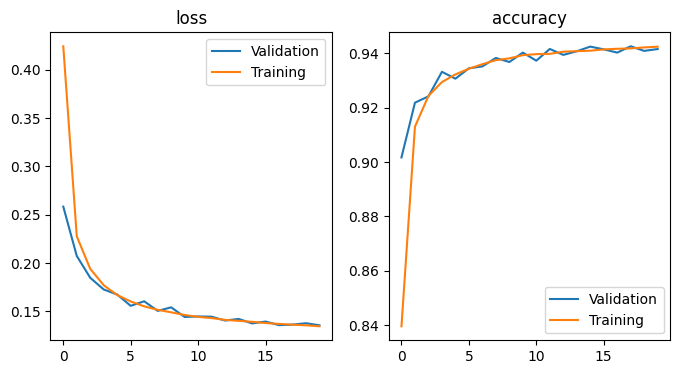

In [ ]:
#Build the DNN model using Sequential()
dnn = Sequential()
dnn.add(Dense(units=32, activation='relu', name='dense1' ))
dnn.add(Dense(units=128, activation='relu', name='dense2'))
dnn.add(Dense(units=7, activation='softmax', name='dense3'))

#initialize Adam Optimizer
optimizer = Adam(learning_rate=0.001)

#Compile the model
dnn.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

#Train the model
training_history = dnn.fit(X_train_dnn, y_train_dnn,
                             epochs = 20,
                             batch_size = 1024,
                             validation_data=(X_test_dnn, y_test_dnn))

#Get Model Summary
dnn.summary()

#Get history plots
plot_acc_loss(training_history.history)

### Random Search

In this section we try to find best hyperparameters thanks to Random Search

#### Model with 3 Layers

In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier #
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform, randint

# Function to create a Keras model
def create_model(input_dim, learning_rate=0.01, units_layer1=32, units_layer2=128):
    model = Sequential()
    model.add(Dense(units=units_layer1, activation='relu', input_dim=input_dim))
    model.add(Dense(units=units_layer2, activation='relu'))
    model.add(Dense(units=7, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Wrap the Keras model for use with scikit-learn
keras_model = KerasClassifier(build_fn=create_model, input_dim=X_train_dnn.shape[1], epochs=20, batch_size=1024, verbose=0, learning_rate=0.01, units_layer1=32, units_layer2=128)

# Specify the hyperparameter search space
param_dist = {
    'units_layer1': randint(16, 64),
    'units_layer2': randint(64, 256),
    'learning_rate': uniform(0.0001, 0.1)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train_dnn, y_train_dnn)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)





In [ ]:
#Best Hyperparameters: {'learning_rate': 0.02541216321016562, 'units_layer1': 37, 'units_layer2': 224}
#Best Accuracy: 0.9422873179292663

#### Model with 4 Layers

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform, randint

# Function to create a Keras model
def create_model(input_dim, learning_rate=0.01, units_layer1=32, units_layer2=128, units_layer3=128):
    model = Sequential()
    model.add(Dense(units=units_layer1, activation='relu', input_dim=input_dim))
    model.add(Dense(units=units_layer2, activation='relu'))
    model.add(Dense(units=units_layer3, activation='relu'))
    model.add(Dense(units=7, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Wrap the Keras model for use with scikit-learn
keras_model = KerasClassifier(build_fn=create_model, input_dim=X_train_dnn.shape[1], epochs=20, batch_size=1024, verbose=0, learning_rate=0.01, units_layer1=32, units_layer2=128, units_layer3=128)

# Specify the hyperparameter search space
param_dist = {
    'units_layer1': randint(16, 64),
    'units_layer2': randint(64, 256),
    'units_layer3': randint(64, 256),
    'learning_rate': uniform(0.0001, 0.2),
    'batch_size': [512, 1024, 10240, 51200],
    'epochs': randint(35, 50, 100)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train_dnn, y_train_dnn)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)





/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best Hyperparameters: {'batch_size': 10240, 'epochs': 148, 'learning_rate': 0.007463521243364324, 'units_layer1': 59, 'units_layer2': 111, 'units_layer3': 112}
Best Accuracy: 0.9522376873950305


In [ ]:
#Best Hyperparameters: {'batch_size': 10240, 'epochs': 148, 'learning_rate': 0.007463521243364324, 'units_layer1': 59, 'units_layer2': 111, 'units_layer3': 112}
#Best Accuracy: 0.9522376873950305

### Reference model with Oversampling

In [ ]:
data_dnn =  prepare_data_for_dnn(X_train_ros, y_train_ros, X_test_ros, y_test_ros)
(X_train_dnn_ros, y_train_dnn_ros), (X_test_dnn_ros, y_test_dnn_ros), (X_valid_dnn_ros, y_valid_dnn_ros) = data_dnn

(3197858, 28)
(3197858,)
(1442644, 28)
(1442644,)
(168309, 28)
(168309,)


Epoch 1/20
3123/3123 [==============================] - 12s 4ms/step - loss: 0.2649 - accuracy: 0.8932 - val_loss: 0.1770 - val_accuracy: 0.9308
Epoch 2/20
3123/3123 [==============================] - 11s 4ms/step - loss: 0.1624 - accuracy: 0.9362 - val_loss: 0.1554 - val_accuracy: 0.9378
Epoch 3/20
3123/3123 [==============================] - 11s 4ms/step - loss: 0.1437 - accuracy: 0.9422 - val_loss: 0.1362 - val_accuracy: 0.9446
Epoch 4/20
3123/3123 [==============================] - 11s 4ms/step - loss: 0.1330 - accuracy: 0.9456 - val_loss: 0.1272 - val_accuracy: 0.9479
Epoch 5/20
3123/3123 [==============================] - 14s 5ms/step - loss: 0.1259 - accuracy: 0.9483 - val_loss: 0.1225 - val_accuracy: 0.9505
Epoch 6/20
3123/3123 [==============================] - 12s 4ms/step - loss: 0.1206 - accuracy: 0.9504 - val_loss: 0.1193 - val_accuracy: 0.9496
Epoch 7/20
3123/3123 [==============================] - 11s 4ms/step - loss: 0.1168 - accuracy: 0.9517 - val_loss: 0.1146 - val_ac

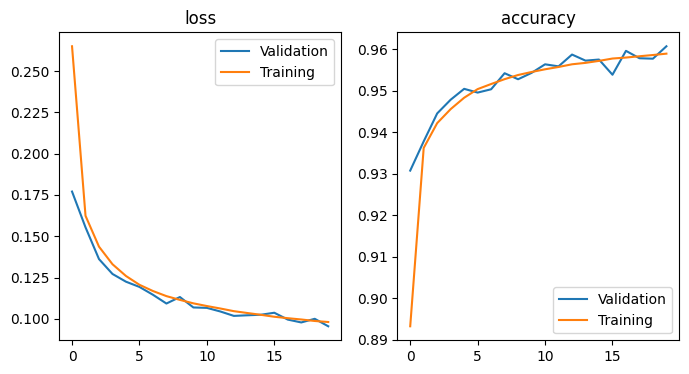

In [ ]:
#Build the DNN model using Sequential()
dnn = Sequential()
dnn.add(Dense(units=32, activation='relu', name='dense1' ))
dnn.add(Dense(units=128, activation='relu', name='dense2'))
dnn.add(Dense(units=7, activation='softmax', name='dense3'))

#initialize Adam Optimizer
optimizer = Adam(learning_rate=0.001)

#Compile the model
dnn.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

#Train the model
training_history = dnn.fit(X_train_dnn_ros, y_train_dnn_ros,
                             epochs = 20,
                             batch_size = 1024,
                             validation_data=(X_test_dnn_ros, y_test_dnn_ros))

#Get Model Summary
dnn.summary()

#Get history plots
plot_acc_loss(training_history.history)



### Final Model

In this section we are using the model obtained from Random Search.

The Model is combined with callbacks\

*   Early stop: to prevent overfitting and unecessary training to spare time

*   ReduceLROnPlateau: To schedule Learning Rates changes





#### With Oversampling

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Using Model obtained by Random Search
dnn = Sequential()
dnn.add(Dense(units=59, activation='relu', name='dense1'))
dnn.add(Dense(units=111, activation='relu', name='dense2'))
dnn.add(Dense(units=112, activation='relu', name='dense3'))
dnn.add(Dense(units=7, activation='softmax', name='dense4'))

# Function to compute Mean ROC AUC (OvR)
def mean_roc_auc(y_true, y_pred):
    return tf.py_function(lambda y_true, y_pred: roc_auc_score(y_true, y_pred, multi_class='ovr'),
                          (y_true, y_pred), tf.float32)

# Function to compute Mean F1-Score (Macro)
def mean_f1_score(y_true, y_pred):
    return tf.py_function(lambda y_true, y_pred: f1_score(y_true, tf.argmax(y_pred, axis=-1), average='macro'),
                          (y_true, y_pred), tf.float32)

optimizer = Adam(learning_rate=0.01)

dnn.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', mean_roc_auc, mean_f1_score])

# Example code for training with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# Set up ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=15, min_lr=1e-5, min_delta=0.05)

# Train the model
training_history = dnn.fit(X_train_dnn_ros, y_train_dnn_ros,
                           epochs=148,
                           batch_size=10240,
                           validation_data=(X_valid_dnn_ros, y_valid_dnn_ros),
                           callbacks=[lr_scheduler, early_stop])

#Save trained DNN model
dnn.save("DNN_classification_os.h5")

Epoch 1/148
313/313 [==============================] - 17s 51ms/step - loss: 0.2389 - accuracy: 0.9009 - mean_roc_auc: 0.9900 - mean_f1_score: 0.8997 - val_loss: 0.1700 - val_accuracy: 0.9294 - val_mean_roc_auc: 0.9960 - val_mean_f1_score: 0.9288 - lr: 0.0100
Epoch 2/148
313/313 [==============================] - 15s 48ms/step - loss: 0.1414 - accuracy: 0.9412 - mean_roc_auc: 0.9970 - mean_f1_score: 0.9411 - val_loss: 0.1286 - val_accuracy: 0.9417 - val_mean_roc_auc: 0.9973 - val_mean_f1_score: 0.9414 - lr: 0.0100
Epoch 3/148
313/313 [==============================] - 15s 47ms/step - loss: 0.1233 - accuracy: 0.9477 - mean_roc_auc: 0.9977 - mean_f1_score: 0.9476 - val_loss: 0.1150 - val_accuracy: 0.9501 - val_mean_roc_auc: 0.9979 - val_mean_f1_score: 0.9496 - lr: 0.0100
Epoch 4/148
313/313 [==============================] - 15s 47ms/step - loss: 0.1130 - accuracy: 0.9521 - mean_roc_auc: 0.9980 - mean_f1_score: 0.9520 - val_loss: 0.1118 - val_accuracy: 0.9512 - val_mean_roc_auc: 0.9981 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 59)                1711      
                                                                 
 dense2 (Dense)              (None, 111)               6660      
                                                                 
 dense3 (Dense)              (None, 112)               12544     
                                                                 
 dense4 (Dense)              (None, 7)                 791       
                                                                 
Total params: 21706 (84.79 KB)
Trainable params: 21706 (84.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


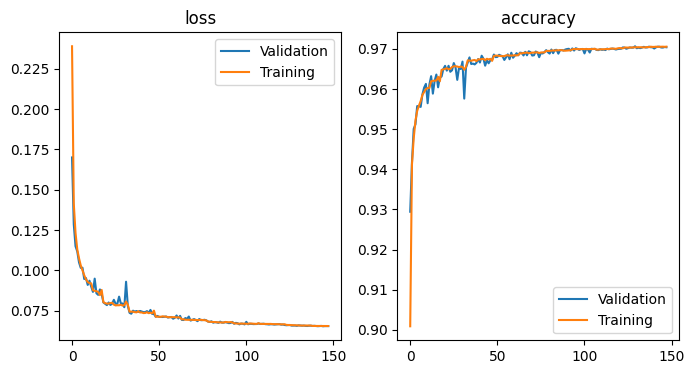

45083/45083 [==============================] - 67s 1ms/step


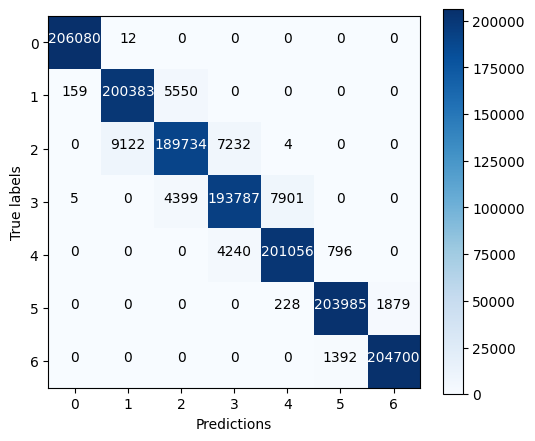

In [ ]:
#Load Saved model
#dnn = load_model('/content/drive/MyDrive/DNN_classification.h5')

# Get model Summary
dnn.summary()

#Get history plots
plot_acc_loss(training_history.history)

# Load Evaluation Data in case of a saved model
#cm, cr, training_history = load_pickle_evaluation_data('/content/drive/MyDrive/dnn_classification_data_os.pkl')

#Calculate and display Confusion Matrix and Classification Report on test Data
cm, cr = get_cm_cr_from_dnn(dnn, X_test_dnn_ros, y_test_dnn_ros)
plot_confusion_matrix(cm)
display_classification_report(cr)

# Pickle evaluation data
save_as_path = '/content/drive/MyDrive/dnn_classification_data_os.pkl'
pickle_model_evaluation_data(save_as_path, cm, cr, training_history)

#### Without Oversampling

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dnn = Sequential()
dnn.add(Dense(units=59, activation='relu', name='dense1'))
dnn.add(Dense(units=111, activation='relu', name='dense2'))
dnn.add(Dense(units=112, activation='relu', name='dense3'))
dnn.add(Dense(units=7, activation='softmax', name='dense4'))

# Function to compute Mean ROC AUC (OvR)
def mean_roc_auc(y_true, y_pred):
    return tf.py_function(lambda y_true, y_pred: roc_auc_score(y_true, y_pred, multi_class='ovr'),
                          (y_true, y_pred), tf.float32)

# Function to compute Mean F1-Score (Macro)
def mean_f1_score(y_true, y_pred):
    return tf.py_function(lambda y_true, y_pred: f1_score(y_true, tf.argmax(y_pred, axis=-1), average='macro'),
                          (y_true, y_pred), tf.float32)

optimizer = Adam(learning_rate=0.01)

dnn.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])#, mean_roc_auc, mean_f1_score])

# Example code for training with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)
# Set up ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=15, min_lr=1e-5, min_delta=0.05)

training_history = dnn.fit(X_train_dnn, y_train_dnn,
                           epochs=148,
                           batch_size=10240,
                           validation_data=(X_valid_dnn, y_valid_dnn),
                           callbacks=[lr_scheduler, early_stop])

Epoch 1/148
104/104 [==============================] - 3s 21ms/step - loss: 0.4035 - accuracy: 0.8365 - val_loss: 0.2280 - val_accuracy: 0.9124 - lr: 0.0100
Epoch 2/148
104/104 [==============================] - 2s 20ms/step - loss: 0.2032 - accuracy: 0.9177 - val_loss: 0.1847 - val_accuracy: 0.9229 - lr: 0.0100
Epoch 3/148
104/104 [==============================] - 2s 22ms/step - loss: 0.1706 - accuracy: 0.9287 - val_loss: 0.1653 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 4/148
104/104 [==============================] - 2s 19ms/step - loss: 0.1607 - accuracy: 0.9322 - val_loss: 0.1556 - val_accuracy: 0.9368 - lr: 0.0100
Epoch 5/148
104/104 [==============================] - 2s 18ms/step - loss: 0.1495 - accuracy: 0.9365 - val_loss: 0.1448 - val_accuracy: 0.9372 - lr: 0.0100
Epoch 6/148
104/104 [==============================] - 2s 19ms/step - loss: 0.1488 - accuracy: 0.9368 - val_loss: 0.1416 - val_accuracy: 0.9422 - lr: 0.0100
Epoch 7/148
104/104 [==============================] - 2s 

In [ ]:
 dnn.save("DNN_classification_no_oversampling.h5") #accuracy0.9564